# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
#run this once to unzip the file
#!unzip processed-celeba-small.zip 

In [2]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision import transforms
import tests
import os


In [3]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [4]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [ToTensor(), Resize(size), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [5]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, directory: str, transforms: Callable = None, extension: str = '.jpg'):
        # TODO: implement the init method
        
        self.directory = directory
        self.transforms = transforms
        self.extension = '.jpg' 
        self.d_list = glob(directory + "*" + extension)

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.d_list)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        img_path = self.d_list[index]
        im = Image.open(img_path)

        im = self.transforms(im)
        
        return im

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

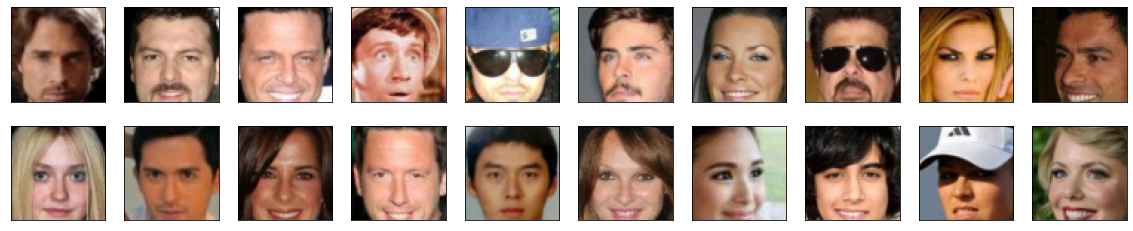

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [8]:
conv_dim = 16

In [ ]:
# custom weights initialization called on discriminator and generator
def costum_weights(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
def conv_block(in_channels, out_channels,kernel_size=4, stride=2, padding=1, b_n=True):
            
    layers = []
    block = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False) # no bias bc of b_n mean=0
            
    layers.append(block)
            
    if b_n:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [10]:
conv_dim = 64

class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
        self.conv_dim = conv_dim
        
        #3x64x64
        self.conv1 = conv_block(3, conv_dim,4, b_n=False) # default kernel_size = 4
        #32x32x32 - conv_dim = 32
        self.conv2 = conv_block(conv_dim, conv_dim*2)
        #64x16x16
        self.conv3 = conv_block(conv_dim*2, conv_dim*4)
        #128x8x8
        self.conv4 = conv_block(conv_dim*4, conv_dim*8)
        #256x4x4
        self.conv5 = conv_block(conv_dim*8, 1, 4, 1, 0, b_n=False)
        #1x1x1

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        #print(x.size())
                
        x = F.leaky_relu(self.conv1(x), 0.2) # slope of leaky relu set to 0.2
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x 

In [11]:
discriminator = Discriminator()
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(costum_weights)

# Print the model
#print(discriminator)

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
### line modified outcommented: discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [13]:
# Helper function for orderly building of layer-blocks

def deconv_block(in_channels, out_channels,kernel_size=4, stride=2, padding=1, b_n=True):
    
    layers = []
         
    trans_block = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False) # no bias bc of b_n mean=0

    layers.append(trans_block)

    if b_n:
        layers.append(nn.BatchNorm2d(out_channels))    
    
    return nn.Sequential(*layers)

In [14]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        # TODO: instantiate the different layers
        self.conv_dim = 64
        
        self.deconv1 = deconv_block(latent_dim, conv_dim*8, 4, 1, 0)
        #256x4x4 
        self.deconv2 = deconv_block(conv_dim*8, conv_dim*4)
        #128x8x8
        self.deconv3 = deconv_block(conv_dim*4, conv_dim*2)
        #64x16x16
        self.deconv4 = deconv_block(conv_dim*2, conv_dim)
        #32x32x32
        self.deconv5 = deconv_block(conv_dim,3, b_n=False) # no batchnorm at generator output
        #3x64x64
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Implement the forward method
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        
        x = torch.tanh(self.deconv5(x))
        
        return x

In [15]:
latent_dim = 128

generator = Generator(latent_dim)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
generator.apply(costum_weights)

# Print the model
print(generator)

Generator(
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv5): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


In [16]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128

## outcommented: generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [17]:
import torch.optim as optim

# parameters
lr = 0.003
beta1=0.5
beta2=0.999 # default value for computer-vision task

def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # Implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
    d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [18]:
# BCELoss is used as Sigmoid is already manually applied on discriminator output

def generator_loss(fake_logits, smooth=False):
    """ Generator loss, takes the fake scores as inputs. """
    # Implement the generator loss 
    ## Real losses
    batch_size = fake_logits.size(0)
    
    if smooth:     
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    
    labels = labels.to(device)   
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(fake_logits.squeeze(), labels)
    
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [19]:
def discriminator_loss(real_logits, fake_logits, smooth=False):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # Implement the discriminator loss 
    
    ## Real losses
    batch_size = real_logits.size(0)
    
    if smooth:    
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    
    labels = labels.to(device)
    criterion = nn.BCELoss()
    real_loss = criterion(real_logits.squeeze(), labels)
    
    ## Fake losses
    batch_size_f = fake_logits.size(0)   
    labels_f = torch.zeros(batch_size_f).to(device)        
    fake_loss = criterion(fake_logits.squeeze(), labels_f)
             
    return real_loss + fake_loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [20]:
# Batch-normalizations are applied which is why gradient penalty was not 

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [21]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # Implement the generator step (foward pass, loss calculation and backward pass)
    g_optimizer.zero_grad()

    # Feeding fake images
    fake_images = generator((torch.randn(batch_size, latent_dim, 1, 1).float().to(device)))
    D_fake = discriminator(fake_images)
    
    # Losses
    g_loss = generator_loss(D_fake, smooth=False)

    # Backpropagation step
    g_loss.backward()
    g_optimizer.step()

    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # Implement the discriminator step (foward pass, loss calculation and backward pass)
    d_optimizer.zero_grad()
    
    batch_size = real_images.size(0)
    
    # Feeding real images
    D_real = discriminator(real_images)

    # Feeding fake images
    fake_images = generator((torch.randn(batch_size, latent_dim, 1, 1).float().to(device)))
    D_fake = discriminator(fake_images)
    
    # Losses
    d_loss = discriminator_loss(D_real, D_fake, smooth=True) # one-sided label smoothing, only discriminator

    # Backpropagation Step
    d_loss.backward()
    d_optimizer.step()
    
    return {'loss': d_loss} # no gradient penalty because of batch_normalizations

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [22]:
from datetime import datetime

In [23]:
# you can experiment with different dimensions of latent spaces
latent_dim = 100

# update to cpu if you do not have access to a gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# number of epochs to train your model
n_epochs = 12

# number of images in each batch
batch_size = 32

In [24]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [25]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2022-04-26 10:25:21 | Epoch [1/12] | Batch 0/509 | d_loss: 1.2684 | g_loss: 0.6931
2022-04-26 10:25:32 | Epoch [1/12] | Batch 50/509 | d_loss: 1.1078 | g_loss: 0.6161
2022-04-26 10:25:43 | Epoch [1/12] | Batch 100/509 | d_loss: 1.7095 | g_loss: 0.5155
2022-04-26 10:25:54 | Epoch [1/12] | Batch 150/509 | d_loss: 1.3698 | g_loss: 0.4874
2022-04-26 10:26:05 | Epoch [1/12] | Batch 200/509 | d_loss: 2.4275 | g_loss: 0.6915
2022-04-26 10:26:16 | Epoch [1/12] | Batch 250/509 | d_loss: 0.4406 | g_loss: 0.6822
2022-04-26 10:26:27 | Epoch [1/12] | Batch 300/509 | d_loss: 1.7115 | g_loss: 0.4967
2022-04-26 10:26:38 | Epoch [1/12] | Batch 350/509 | d_loss: 0.9026 | g_loss: 0.6856
2022-04-26 10:26:49 | Epoch [1/12] | Batch 400/509 | d_loss: 1.3767 | g_loss: 0.5602
2022-04-26 10:27:00 | Epoch [1/12] | Batch 450/509 | d_loss: 1.1386 | g_loss: 0.6032
2022-04-26 10:27:11 | Epoch [1/12] | Batch 500/509 | d_loss: 0.8109 | g_loss: 0.6618


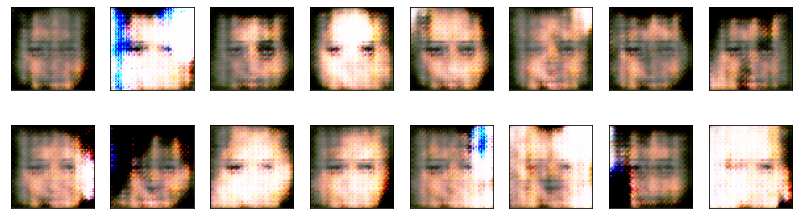

2022-04-26 10:27:14 | Epoch [2/12] | Batch 0/509 | d_loss: 0.9575 | g_loss: 0.5693
2022-04-26 10:27:24 | Epoch [2/12] | Batch 50/509 | d_loss: 1.2229 | g_loss: 0.5998
2022-04-26 10:27:35 | Epoch [2/12] | Batch 100/509 | d_loss: 1.0893 | g_loss: 0.6490
2022-04-26 10:27:46 | Epoch [2/12] | Batch 150/509 | d_loss: 1.1122 | g_loss: 0.5455
2022-04-26 10:27:57 | Epoch [2/12] | Batch 200/509 | d_loss: 0.4331 | g_loss: 0.6884
2022-04-26 10:28:08 | Epoch [2/12] | Batch 250/509 | d_loss: 0.7180 | g_loss: 0.5370
2022-04-26 10:28:19 | Epoch [2/12] | Batch 300/509 | d_loss: 1.0292 | g_loss: 0.5592
2022-04-26 10:28:30 | Epoch [2/12] | Batch 350/509 | d_loss: 0.8056 | g_loss: 0.6196
2022-04-26 10:28:41 | Epoch [2/12] | Batch 400/509 | d_loss: 1.0098 | g_loss: 0.5861
2022-04-26 10:28:51 | Epoch [2/12] | Batch 450/509 | d_loss: 1.1908 | g_loss: 0.5371
2022-04-26 10:29:02 | Epoch [2/12] | Batch 500/509 | d_loss: 0.7143 | g_loss: 0.6542


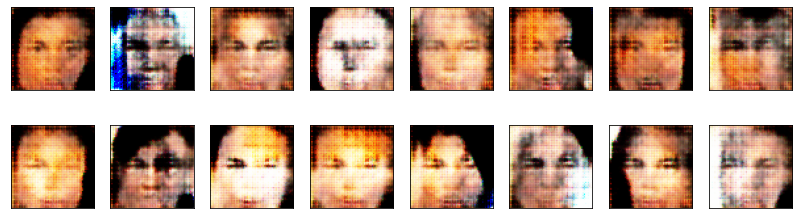

2022-04-26 10:29:05 | Epoch [3/12] | Batch 0/509 | d_loss: 0.9348 | g_loss: 0.6791
2022-04-26 10:29:16 | Epoch [3/12] | Batch 50/509 | d_loss: 0.8840 | g_loss: 0.6313
2022-04-26 10:29:27 | Epoch [3/12] | Batch 100/509 | d_loss: 0.8244 | g_loss: 0.6127
2022-04-26 10:29:38 | Epoch [3/12] | Batch 150/509 | d_loss: 0.6470 | g_loss: 0.6724
2022-04-26 10:29:49 | Epoch [3/12] | Batch 200/509 | d_loss: 0.5726 | g_loss: 0.6538
2022-04-26 10:30:00 | Epoch [3/12] | Batch 250/509 | d_loss: 0.7170 | g_loss: 0.6737
2022-04-26 10:30:10 | Epoch [3/12] | Batch 300/509 | d_loss: 0.8227 | g_loss: 0.6308
2022-04-26 10:30:21 | Epoch [3/12] | Batch 350/509 | d_loss: 1.1643 | g_loss: 0.6906
2022-04-26 10:30:32 | Epoch [3/12] | Batch 400/509 | d_loss: 0.9439 | g_loss: 0.6794
2022-04-26 10:30:43 | Epoch [3/12] | Batch 450/509 | d_loss: 1.1338 | g_loss: 0.6088
2022-04-26 10:30:54 | Epoch [3/12] | Batch 500/509 | d_loss: 0.7981 | g_loss: 0.6657


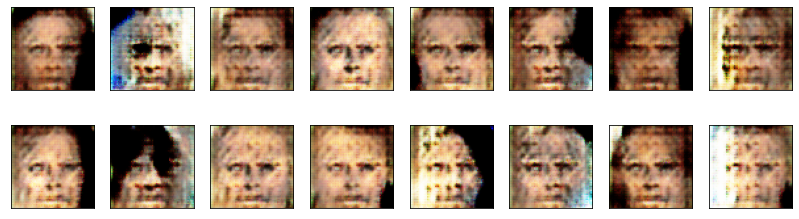

2022-04-26 10:30:57 | Epoch [4/12] | Batch 0/509 | d_loss: 0.8238 | g_loss: 0.6305
2022-04-26 10:31:08 | Epoch [4/12] | Batch 50/509 | d_loss: 1.1507 | g_loss: 0.6915
2022-04-26 10:31:19 | Epoch [4/12] | Batch 100/509 | d_loss: 2.0129 | g_loss: 0.6923
2022-04-26 10:31:30 | Epoch [4/12] | Batch 150/509 | d_loss: 0.7866 | g_loss: 0.6072
2022-04-26 10:31:41 | Epoch [4/12] | Batch 200/509 | d_loss: 0.6989 | g_loss: 0.6691
2022-04-26 10:31:51 | Epoch [4/12] | Batch 250/509 | d_loss: 0.5373 | g_loss: 0.6724
2022-04-26 10:32:02 | Epoch [4/12] | Batch 300/509 | d_loss: 0.5713 | g_loss: 0.6862
2022-04-26 10:32:13 | Epoch [4/12] | Batch 350/509 | d_loss: 0.6003 | g_loss: 0.6761
2022-04-26 10:32:24 | Epoch [4/12] | Batch 400/509 | d_loss: 1.1865 | g_loss: 0.6716
2022-04-26 10:32:35 | Epoch [4/12] | Batch 450/509 | d_loss: 1.1819 | g_loss: 0.6824
2022-04-26 10:32:46 | Epoch [4/12] | Batch 500/509 | d_loss: 0.6978 | g_loss: 0.6334


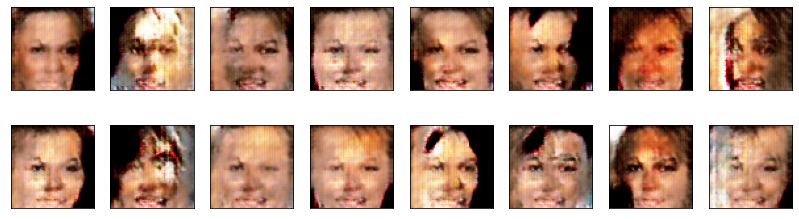

2022-04-26 10:32:49 | Epoch [5/12] | Batch 0/509 | d_loss: 0.6296 | g_loss: 0.6509
2022-04-26 10:33:00 | Epoch [5/12] | Batch 50/509 | d_loss: 0.5815 | g_loss: 0.5890
2022-04-26 10:33:10 | Epoch [5/12] | Batch 100/509 | d_loss: 0.9359 | g_loss: 0.6419
2022-04-26 10:33:21 | Epoch [5/12] | Batch 150/509 | d_loss: 0.7012 | g_loss: 0.6566
2022-04-26 10:33:32 | Epoch [5/12] | Batch 200/509 | d_loss: 0.5633 | g_loss: 0.6540
2022-04-26 10:33:43 | Epoch [5/12] | Batch 250/509 | d_loss: 2.0333 | g_loss: 0.6478
2022-04-26 10:33:54 | Epoch [5/12] | Batch 300/509 | d_loss: 1.2783 | g_loss: 0.6759
2022-04-26 10:34:05 | Epoch [5/12] | Batch 350/509 | d_loss: 0.9692 | g_loss: 0.6744
2022-04-26 10:34:16 | Epoch [5/12] | Batch 400/509 | d_loss: 0.8045 | g_loss: 0.6292
2022-04-26 10:34:27 | Epoch [5/12] | Batch 450/509 | d_loss: 0.8202 | g_loss: 0.6628
2022-04-26 10:34:37 | Epoch [5/12] | Batch 500/509 | d_loss: 0.9051 | g_loss: 0.6879


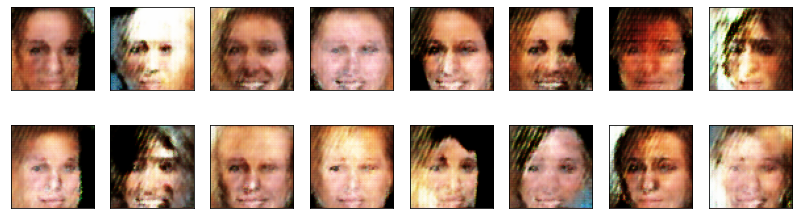

2022-04-26 10:34:40 | Epoch [6/12] | Batch 0/509 | d_loss: 1.0068 | g_loss: 0.6722
2022-04-26 10:34:51 | Epoch [6/12] | Batch 50/509 | d_loss: 0.6345 | g_loss: 0.6569
2022-04-26 10:35:02 | Epoch [6/12] | Batch 100/509 | d_loss: 1.4944 | g_loss: 0.6812
2022-04-26 10:35:13 | Epoch [6/12] | Batch 150/509 | d_loss: 2.0431 | g_loss: 0.6551
2022-04-26 10:35:24 | Epoch [6/12] | Batch 200/509 | d_loss: 0.5526 | g_loss: 0.6813
2022-04-26 10:35:35 | Epoch [6/12] | Batch 250/509 | d_loss: 0.6702 | g_loss: 0.6648
2022-04-26 10:35:46 | Epoch [6/12] | Batch 300/509 | d_loss: 0.5157 | g_loss: 0.6765
2022-04-26 10:35:57 | Epoch [6/12] | Batch 350/509 | d_loss: 0.5540 | g_loss: 0.6675
2022-04-26 10:36:07 | Epoch [6/12] | Batch 400/509 | d_loss: 1.1437 | g_loss: 0.5914
2022-04-26 10:36:18 | Epoch [6/12] | Batch 450/509 | d_loss: 0.6963 | g_loss: 0.6645
2022-04-26 10:36:29 | Epoch [6/12] | Batch 500/509 | d_loss: 0.7089 | g_loss: 0.6610


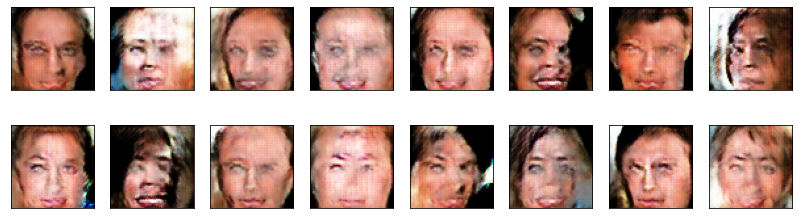

2022-04-26 10:36:32 | Epoch [7/12] | Batch 0/509 | d_loss: 0.5881 | g_loss: 0.6263
2022-04-26 10:36:43 | Epoch [7/12] | Batch 50/509 | d_loss: 0.7699 | g_loss: 0.6586
2022-04-26 10:36:54 | Epoch [7/12] | Batch 100/509 | d_loss: 0.6641 | g_loss: 0.6707
2022-04-26 10:37:05 | Epoch [7/12] | Batch 150/509 | d_loss: 0.6087 | g_loss: 0.6788
2022-04-26 10:37:16 | Epoch [7/12] | Batch 200/509 | d_loss: 0.7253 | g_loss: 0.6647
2022-04-26 10:37:26 | Epoch [7/12] | Batch 250/509 | d_loss: 0.5011 | g_loss: 0.6823
2022-04-26 10:37:37 | Epoch [7/12] | Batch 300/509 | d_loss: 0.6522 | g_loss: 0.6553
2022-04-26 10:37:48 | Epoch [7/12] | Batch 350/509 | d_loss: 0.7046 | g_loss: 0.6483
2022-04-26 10:37:59 | Epoch [7/12] | Batch 400/509 | d_loss: 1.0041 | g_loss: 0.6541
2022-04-26 10:38:10 | Epoch [7/12] | Batch 450/509 | d_loss: 0.9425 | g_loss: 0.6677
2022-04-26 10:38:21 | Epoch [7/12] | Batch 500/509 | d_loss: 0.9904 | g_loss: 0.6853


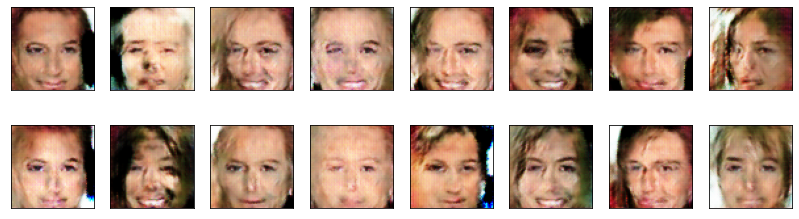

2022-04-26 10:38:24 | Epoch [8/12] | Batch 0/509 | d_loss: 0.6221 | g_loss: 0.6698
2022-04-26 10:38:35 | Epoch [8/12] | Batch 50/509 | d_loss: 0.9245 | g_loss: 0.6867
2022-04-26 10:38:46 | Epoch [8/12] | Batch 100/509 | d_loss: 0.8585 | g_loss: 0.6201
2022-04-26 10:38:57 | Epoch [8/12] | Batch 150/509 | d_loss: 0.6872 | g_loss: 0.6301
2022-04-26 10:39:07 | Epoch [8/12] | Batch 200/509 | d_loss: 1.1076 | g_loss: 0.6406
2022-04-26 10:39:18 | Epoch [8/12] | Batch 250/509 | d_loss: 0.6573 | g_loss: 0.6679
2022-04-26 10:39:29 | Epoch [8/12] | Batch 300/509 | d_loss: 0.8768 | g_loss: 0.6610
2022-04-26 10:39:40 | Epoch [8/12] | Batch 350/509 | d_loss: 1.8297 | g_loss: 0.6631
2022-04-26 10:39:51 | Epoch [8/12] | Batch 400/509 | d_loss: 0.8123 | g_loss: 0.6637
2022-04-26 10:40:02 | Epoch [8/12] | Batch 450/509 | d_loss: 0.7533 | g_loss: 0.6583
2022-04-26 10:40:13 | Epoch [8/12] | Batch 500/509 | d_loss: 1.4646 | g_loss: 0.6864


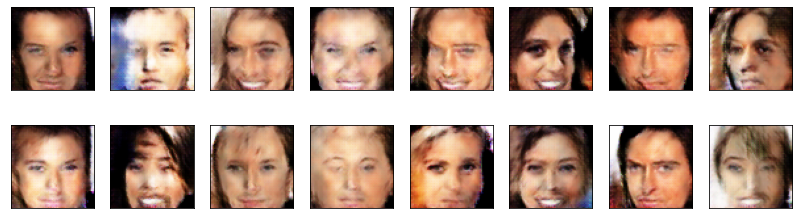

2022-04-26 10:40:16 | Epoch [9/12] | Batch 0/509 | d_loss: 0.7887 | g_loss: 0.6303
2022-04-26 10:40:26 | Epoch [9/12] | Batch 50/509 | d_loss: 0.5264 | g_loss: 0.6338
2022-04-26 10:40:37 | Epoch [9/12] | Batch 100/509 | d_loss: 0.8423 | g_loss: 0.6489
2022-04-26 10:40:48 | Epoch [9/12] | Batch 150/509 | d_loss: 0.7317 | g_loss: 0.6844
2022-04-26 10:40:59 | Epoch [9/12] | Batch 200/509 | d_loss: 1.0013 | g_loss: 0.6563
2022-04-26 10:41:10 | Epoch [9/12] | Batch 250/509 | d_loss: 1.3572 | g_loss: 0.6368
2022-04-26 10:41:21 | Epoch [9/12] | Batch 300/509 | d_loss: 0.5224 | g_loss: 0.6478
2022-04-26 10:41:32 | Epoch [9/12] | Batch 350/509 | d_loss: 0.7670 | g_loss: 0.6576
2022-04-26 10:41:43 | Epoch [9/12] | Batch 400/509 | d_loss: 0.7313 | g_loss: 0.6190
2022-04-26 10:41:53 | Epoch [9/12] | Batch 450/509 | d_loss: 0.6255 | g_loss: 0.6671
2022-04-26 10:42:04 | Epoch [9/12] | Batch 500/509 | d_loss: 1.0356 | g_loss: 0.6012


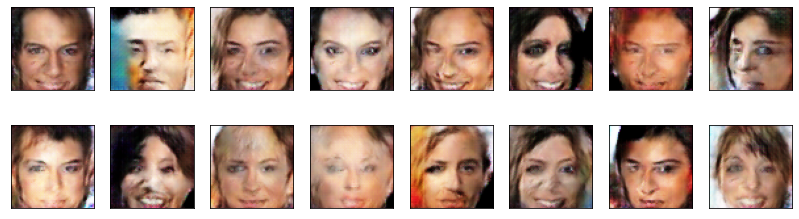

2022-04-26 10:42:07 | Epoch [10/12] | Batch 0/509 | d_loss: 0.6706 | g_loss: 0.6379
2022-04-26 10:42:18 | Epoch [10/12] | Batch 50/509 | d_loss: 0.7279 | g_loss: 0.6627
2022-04-26 10:42:29 | Epoch [10/12] | Batch 100/509 | d_loss: 0.7220 | g_loss: 0.6716
2022-04-26 10:42:40 | Epoch [10/12] | Batch 150/509 | d_loss: 1.3956 | g_loss: 0.6902
2022-04-26 10:42:51 | Epoch [10/12] | Batch 200/509 | d_loss: 0.6499 | g_loss: 0.6685
2022-04-26 10:43:02 | Epoch [10/12] | Batch 250/509 | d_loss: 0.7265 | g_loss: 0.6760
2022-04-26 10:43:12 | Epoch [10/12] | Batch 300/509 | d_loss: 0.5354 | g_loss: 0.6708
2022-04-26 10:43:23 | Epoch [10/12] | Batch 350/509 | d_loss: 0.6931 | g_loss: 0.6897
2022-04-26 10:43:34 | Epoch [10/12] | Batch 400/509 | d_loss: 0.5347 | g_loss: 0.6790
2022-04-26 10:43:45 | Epoch [10/12] | Batch 450/509 | d_loss: 0.9513 | g_loss: 0.6843
2022-04-26 10:43:56 | Epoch [10/12] | Batch 500/509 | d_loss: 0.5409 | g_loss: 0.6785


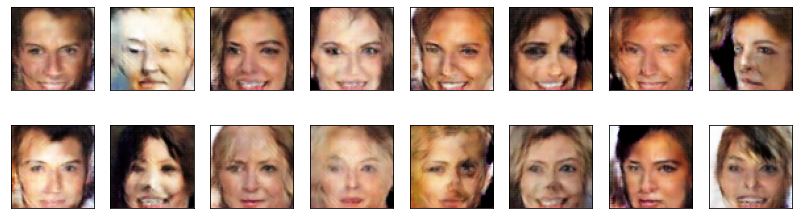

2022-04-26 10:43:59 | Epoch [11/12] | Batch 0/509 | d_loss: 0.8349 | g_loss: 0.6712
2022-04-26 10:44:10 | Epoch [11/12] | Batch 50/509 | d_loss: 0.6835 | g_loss: 0.6777
2022-04-26 10:44:21 | Epoch [11/12] | Batch 100/509 | d_loss: 0.6115 | g_loss: 0.6758
2022-04-26 10:44:32 | Epoch [11/12] | Batch 150/509 | d_loss: 0.5437 | g_loss: 0.6852
2022-04-26 10:44:42 | Epoch [11/12] | Batch 200/509 | d_loss: 0.5121 | g_loss: 0.6694
2022-04-26 10:44:53 | Epoch [11/12] | Batch 250/509 | d_loss: 0.5890 | g_loss: 0.6692
2022-04-26 10:45:04 | Epoch [11/12] | Batch 300/509 | d_loss: 0.6270 | g_loss: 0.6710
2022-04-26 10:45:15 | Epoch [11/12] | Batch 350/509 | d_loss: 0.7034 | g_loss: 0.6886
2022-04-26 10:45:26 | Epoch [11/12] | Batch 400/509 | d_loss: 0.6312 | g_loss: 0.6652
2022-04-26 10:45:37 | Epoch [11/12] | Batch 450/509 | d_loss: 0.6666 | g_loss: 0.6541
2022-04-26 10:45:48 | Epoch [11/12] | Batch 500/509 | d_loss: 0.6443 | g_loss: 0.6403


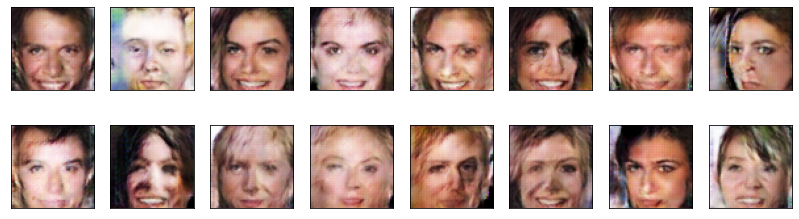

2022-04-26 10:45:51 | Epoch [12/12] | Batch 0/509 | d_loss: 1.4799 | g_loss: 0.6505
2022-04-26 10:46:01 | Epoch [12/12] | Batch 50/509 | d_loss: 0.5230 | g_loss: 0.6489
2022-04-26 10:46:12 | Epoch [12/12] | Batch 100/509 | d_loss: 0.7202 | g_loss: 0.5967
2022-04-26 10:46:23 | Epoch [12/12] | Batch 150/509 | d_loss: 1.1853 | g_loss: 0.5623
2022-04-26 10:46:34 | Epoch [12/12] | Batch 200/509 | d_loss: 0.4672 | g_loss: 0.6682
2022-04-26 10:46:45 | Epoch [12/12] | Batch 250/509 | d_loss: 0.6308 | g_loss: 0.6249
2022-04-26 10:46:56 | Epoch [12/12] | Batch 300/509 | d_loss: 0.5332 | g_loss: 0.6741
2022-04-26 10:47:07 | Epoch [12/12] | Batch 350/509 | d_loss: 0.6094 | g_loss: 0.6700
2022-04-26 10:47:18 | Epoch [12/12] | Batch 400/509 | d_loss: 0.5934 | g_loss: 0.6749
2022-04-26 10:47:28 | Epoch [12/12] | Batch 450/509 | d_loss: 0.3994 | g_loss: 0.6873
2022-04-26 10:47:39 | Epoch [12/12] | Batch 500/509 | d_loss: 0.5637 | g_loss: 0.6695


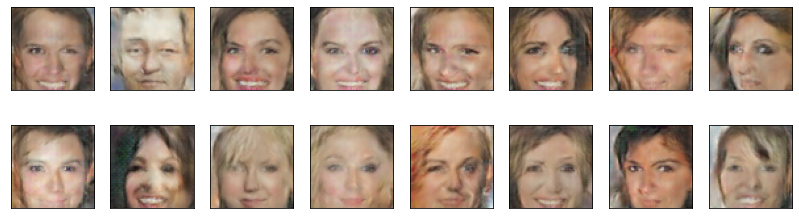

In [26]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        ## Discriminator Training
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        
        ## Generator Training
        g_loss = generator_step(batch_size, latent_dim)
        
        
        ####################################
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

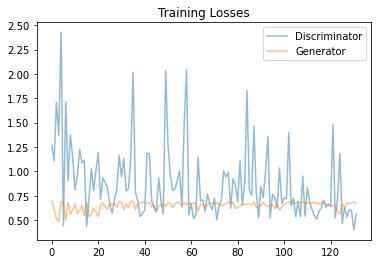

In [27]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** <span style="color: blue;">Overall the model is geared towards generating realistic images, limitations are that the dataset as of now is trained in an imbalanced way, in essence this means that many features are not only overrepresented in the dataset, as e.g. caucasian ethnicity, but also that certain features are recognized better by the model, and therefore easier trained than others, these e.g. include lipstick or long hair. To overcome this, features which are harder to be trained, like nuances in skin color or smaller facial features like eye shape, could be identified and oversampled, additionally more abstract and advanced data augmentation techniques can help the filters to extract more useful information from the enlargened dataset.
Batch normalizations where applied as the standard, which can be switched to gradient penalty in trials, also Wasserstein Loss is a new approach that may lead to better optimizations.
Artifacts remaining from partial generation of glasses or earings can be approached by adapting key-components from ProgressiveGAN and StyleGAN, like InterFaceGAN for Semantic Face Editing.</span>

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.